In [187]:
import numpy as np 
import pandas as pd
from copy import deepcopy
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import explained_variance_score,mean_absolute_error,r2_score
from time import time

from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xg
from sklearn.model_selection import GridSearchCV
from shap import TreeExplainer
import shap
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn import svm
from sklearn.feature_selection import VarianceThreshold

In [188]:
data = pd.read_pickle('test_data.pickle')

## Первичный осмотр данных

### Категориальные признаки

In [189]:
cat_columns = [i for i in data.columns if data[i].dtype=='object' and i not in ['session_id','user_id','hospital_id','date_service','session_start_date','session_end_date']]

In [190]:
cat_columns

['session_status',
 'segment',
 'channel',
 'subchannel',
 'service_category',
 'doctor_specialization',
 'doctor_speciality',
 'physiotherapy_type',
 'diagnostics_type',
 'laboratory_type',
 'consultation_type']

The figure layout has changed to tight
The figure layout has changed to tight
The figure layout has changed to tight
The figure layout has changed to tight
The figure layout has changed to tight
The figure layout has changed to tight
The figure layout has changed to tight
The figure layout has changed to tight
The figure layout has changed to tight
The figure layout has changed to tight


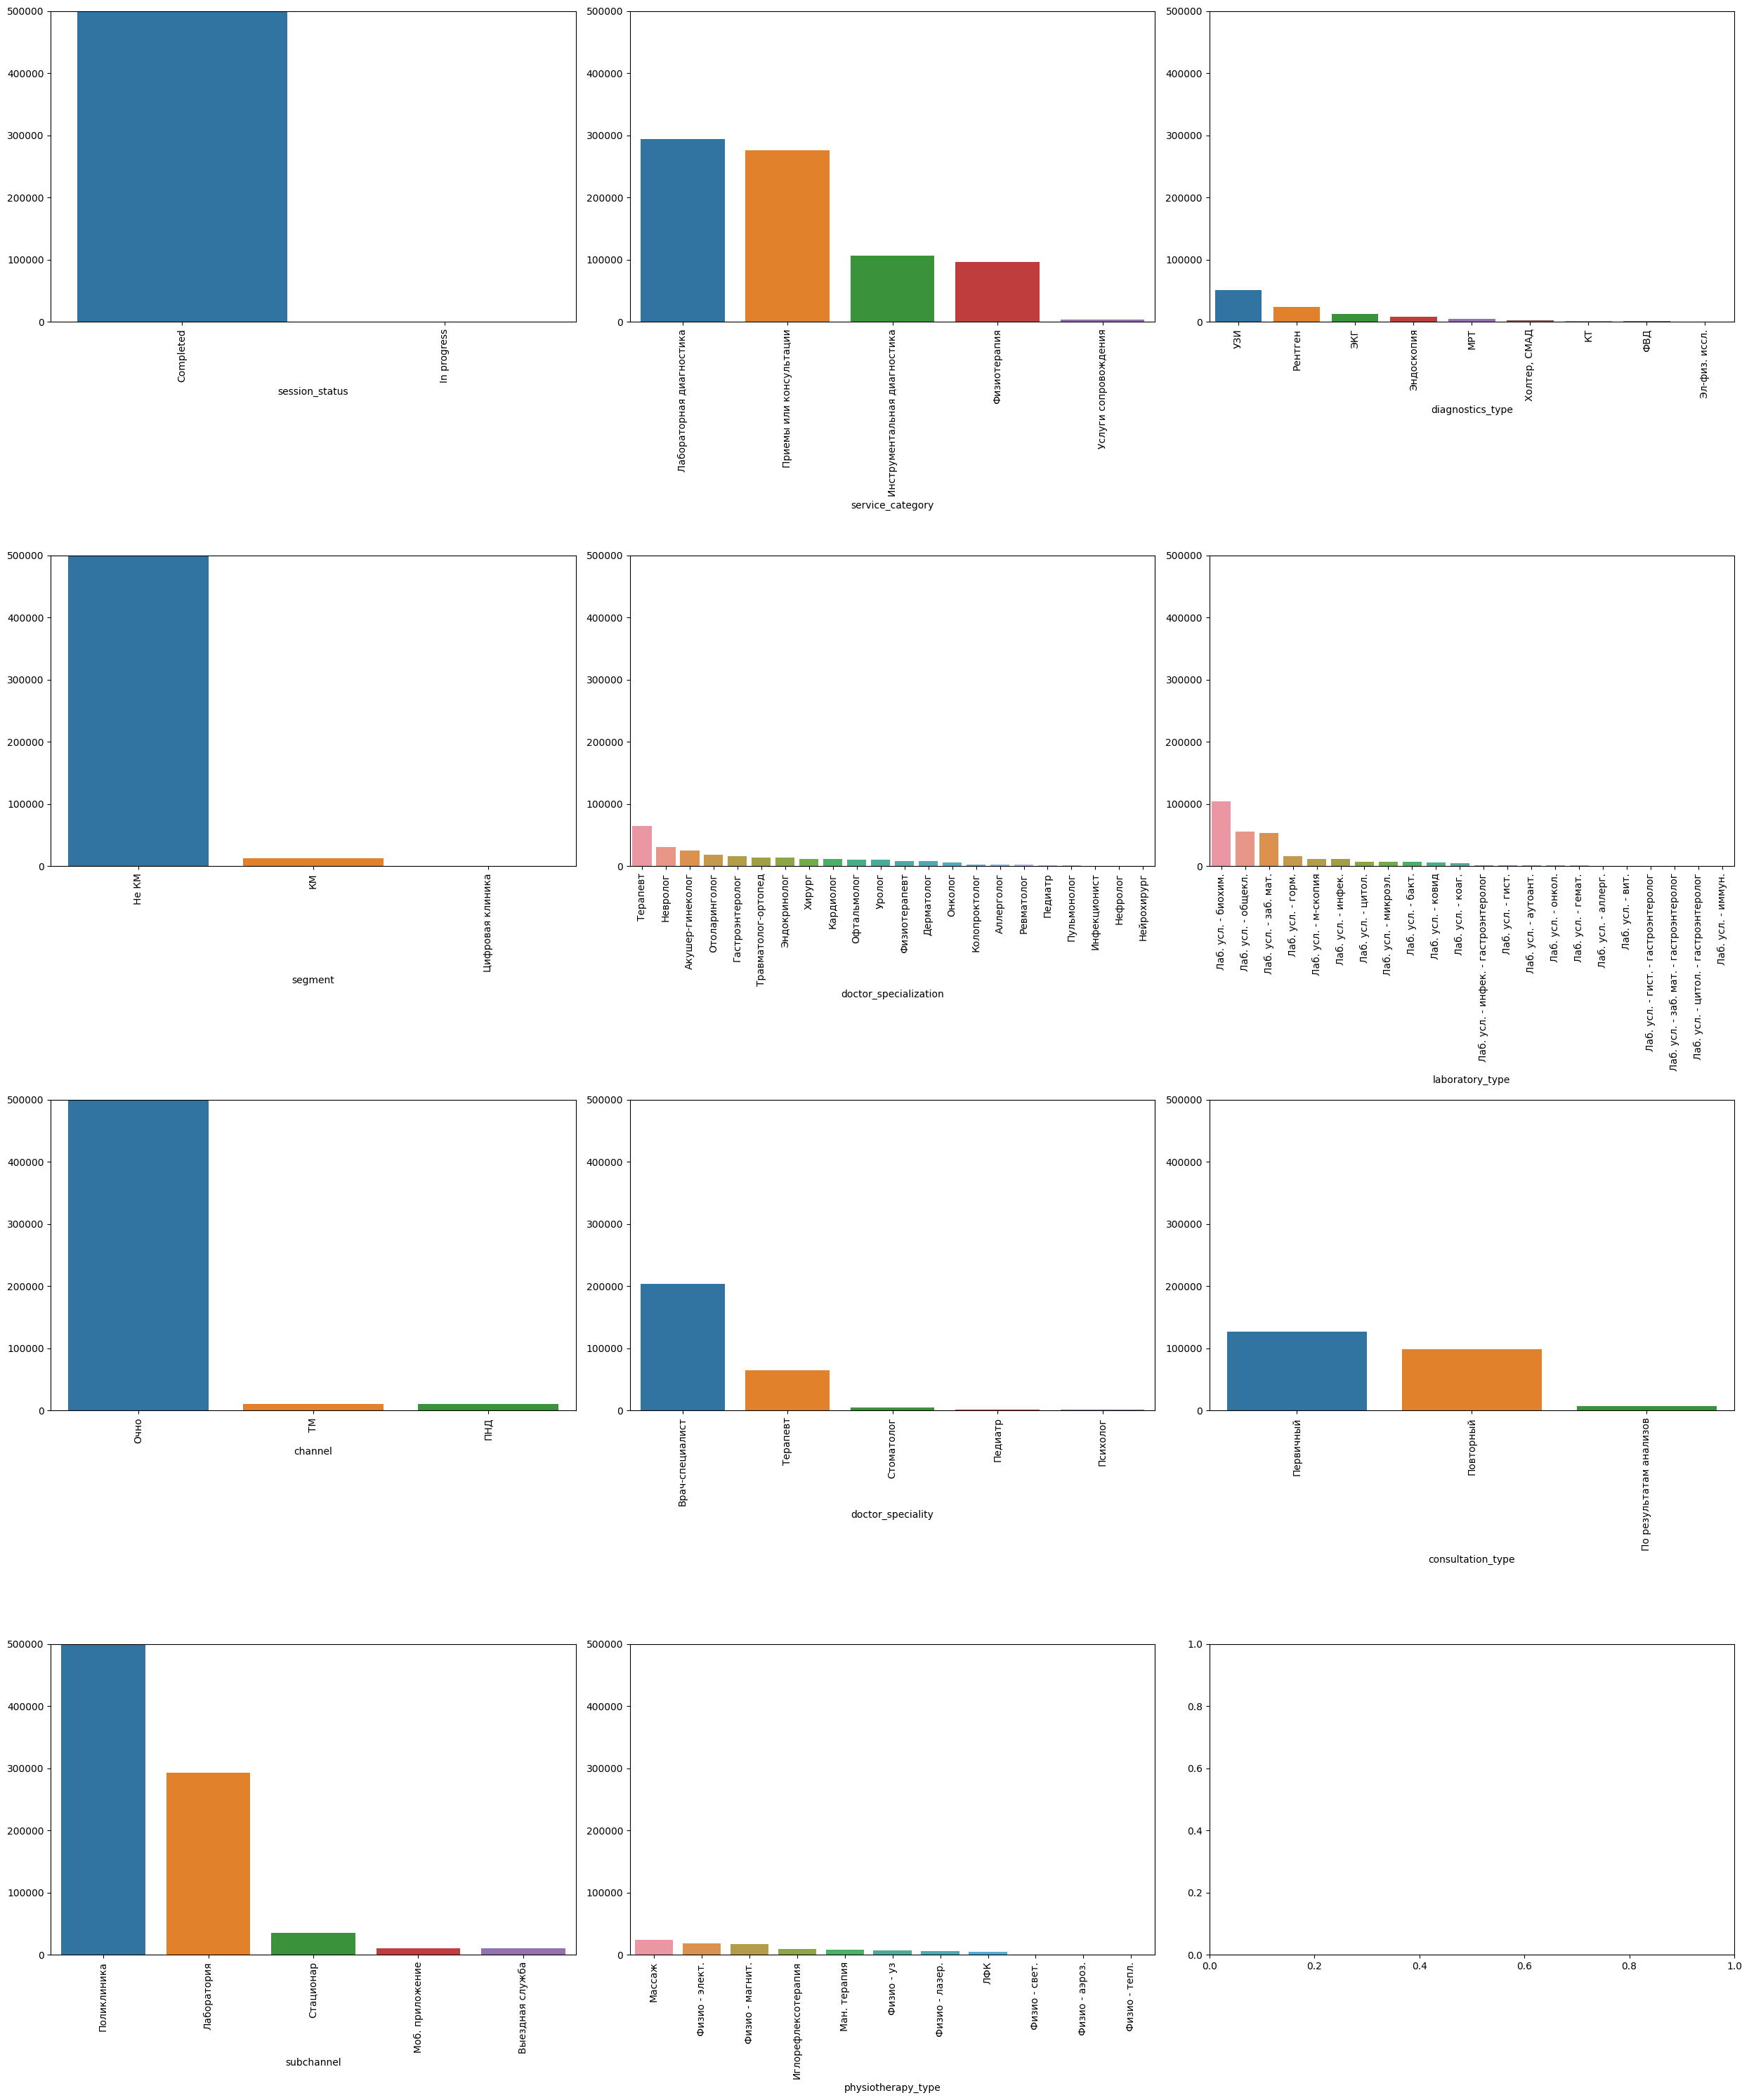

In [191]:
fig, axs = plt.subplots(4,3, figsize=(25, 30))
row=0
col=0
for num in range(len(cat_columns)):
    if col>3:
        col=0
        row+=1
        sns.barplot(data=pd.DataFrame(data[cat_columns[num]].value_counts()).T,ax=axs[col,row])
        axs[col,row].set_xticklabels(axs[col,row].get_xticklabels(),rotation=90)
        axs[col,row].set_ylim([0,500000])
    else:
        sns.barplot(data=pd.DataFrame(data[cat_columns[num]].value_counts()).T,ax=axs[col,row])
        axs[col,row].set_xticklabels(axs[col,row].get_xticklabels(),rotation=90)
        axs[col,row].set_ylim([0,500000])
    col+=1
    plt.tight_layout()

Видим, что во многих категориях, есть значение, которое занимает большую часть данных - это нам поможет при заполнении пропусков и кодировании категориальных признаков

### Количественные признаки

In [192]:
num_columns = [i for i in data.columns if data[i].dtype!='object' and i not in ['session_id','user_id','hospital_id','date_service','session_start_date','session_end_date']]

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
The figure layout has changed to tight
FixedFormatter should only be used together with FixedLocator
The figure layout has changed to tight
FixedFormatter should only be used together with FixedLocator
The figure layout has changed to tight


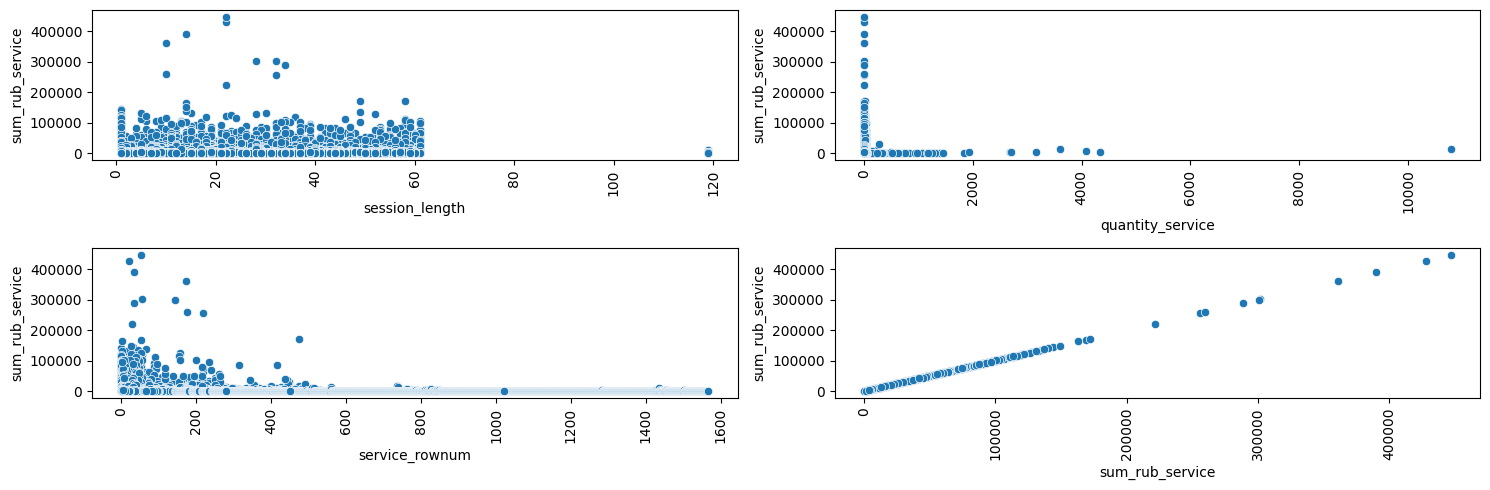

In [193]:
fig, axs = plt.subplots(2,2, figsize=(15, 5))
row=0
col=0
for num in range(len(num_columns)):
    if col>1:
        col=0
        row+=1
        sns.scatterplot(x=data[num_columns[num]],y=data['sum_rub_service'],ax=axs[col,row])
        axs[col,row].set_xticklabels(axs[col,row].get_xticklabels(),rotation=90)
    else:
        sns.scatterplot(x=data[num_columns[num]],y=data['sum_rub_service'],ax=axs[col,row])
        axs[col,row].set_xticklabels(axs[col,row].get_xticklabels(),rotation=90)
    col+=1
    plt.tight_layout()

Есть колонки с явными выбросами - **session_length, quantity_service, sub_rub_service**. Удалим их из анализа

<Axes: xlabel='session_length', ylabel='sum_rub_service'>

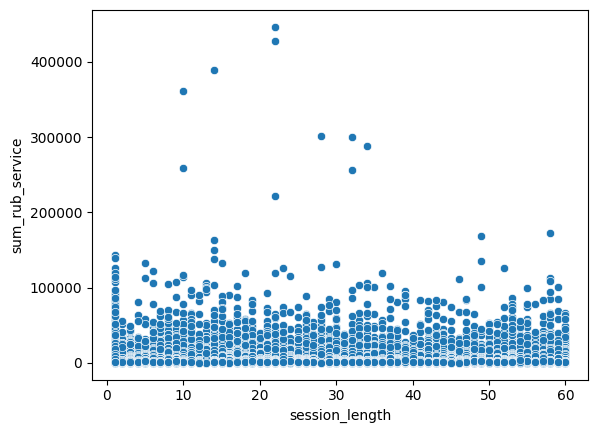

In [194]:
top_quantile = data['session_length'].quantile(0.975)
low_quantile = data['session_length'].quantile(0.025)
data = data[(data['session_length']>=low_quantile)&(data['session_length']<=top_quantile)]
sns.scatterplot(x=data['session_length'],y=data['sum_rub_service'])

<Axes: xlabel='quantity_service', ylabel='sum_rub_service'>

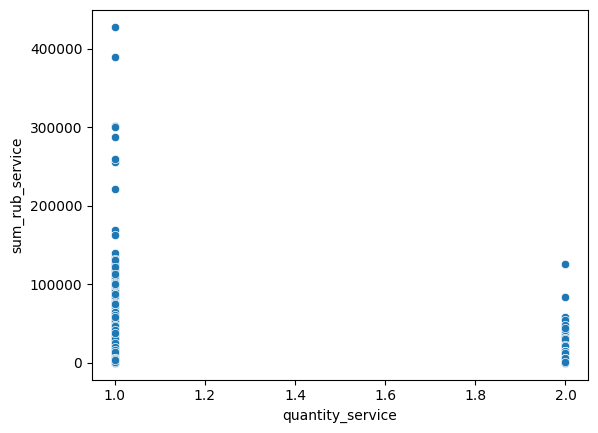

In [195]:
top_quantile = data['quantity_service'].quantile(0.975)
low_quantile = data['quantity_service'].quantile(0.025)
data = data[(data['quantity_service']>=low_quantile)&(data['quantity_service']<=top_quantile)]
sns.scatterplot(x=data['quantity_service'],y=data['sum_rub_service'])

The figure layout has changed to tight
The figure layout has changed to tight
The figure layout has changed to tight
The figure layout has changed to tight
The figure layout has changed to tight
The figure layout has changed to tight
The figure layout has changed to tight
The figure layout has changed to tight
The figure layout has changed to tight
The figure layout has changed to tight


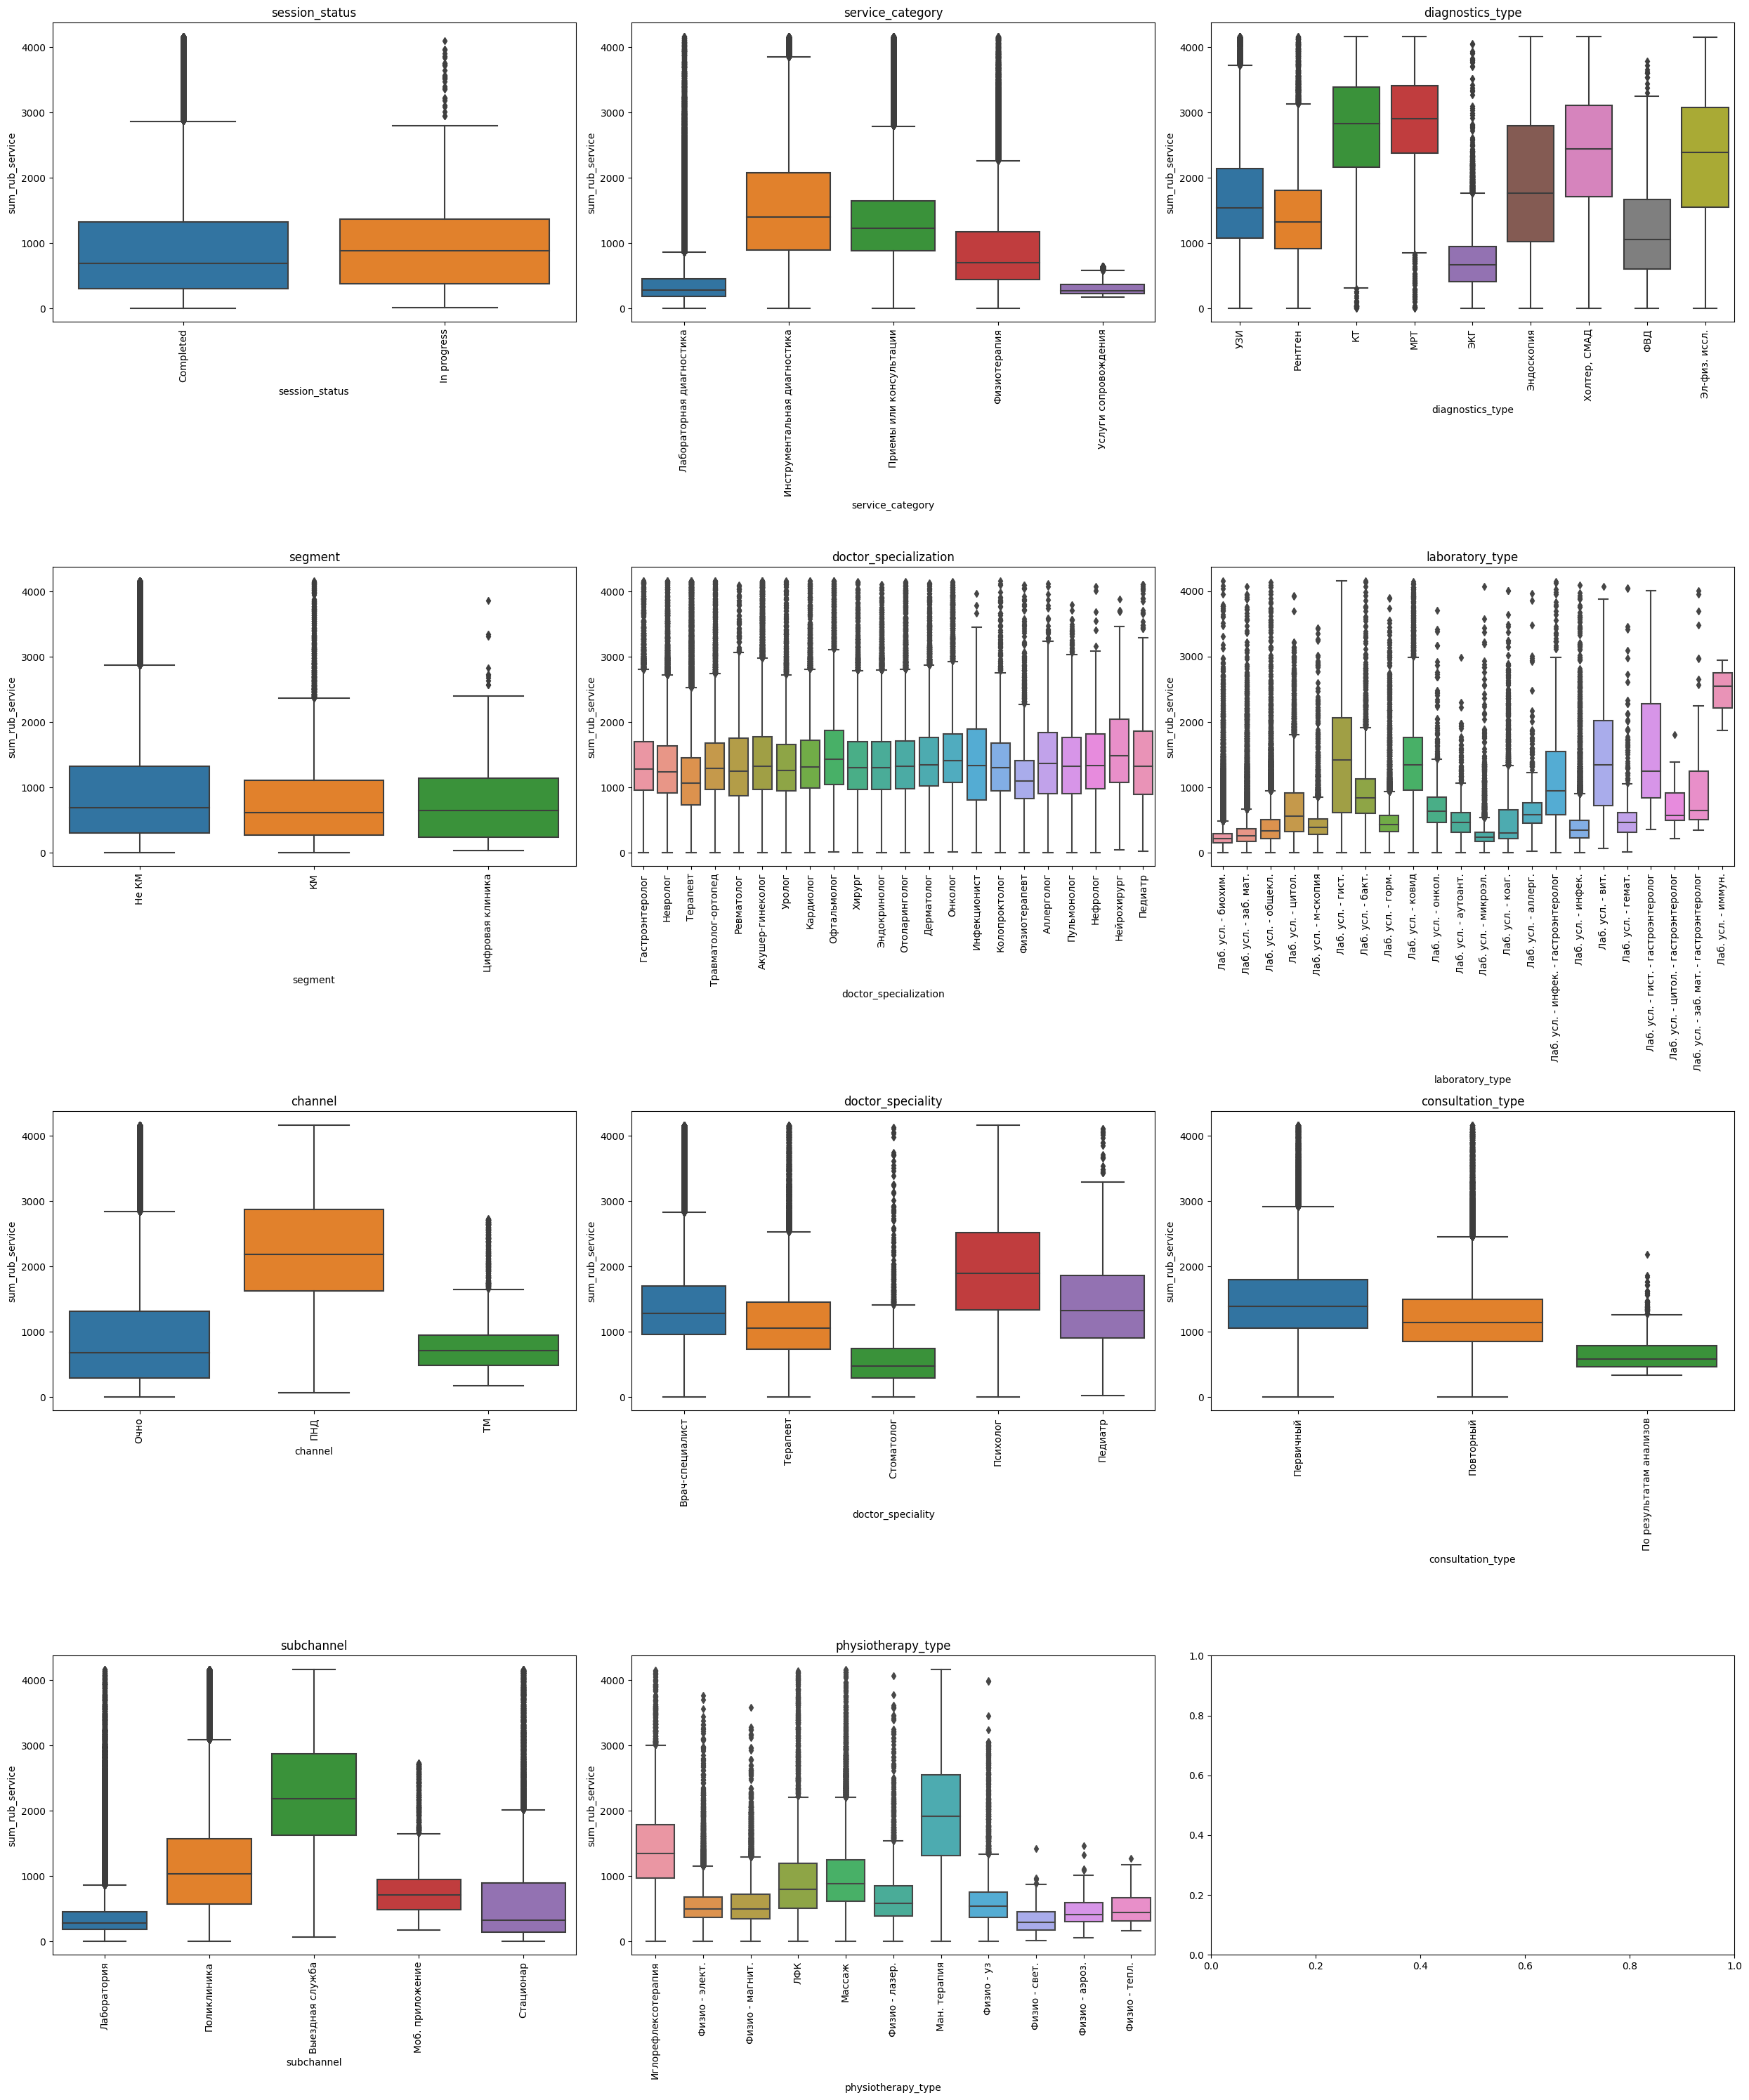

In [196]:
top_quantile = data['sum_rub_service'].quantile(0.975)
low_quantile = data['sum_rub_service'].quantile(0.025)
data = data[(data['sum_rub_service']>=low_quantile)&(data['sum_rub_service']<=top_quantile)]
fig, axs = plt.subplots(4,3, figsize=(25, 30))
row=0
col=0
for num in range(len(cat_columns)):
    if col>3:
        col=0
        row+=1
        sns.boxplot(x=data[cat_columns[num]],y=data['sum_rub_service'],ax=axs[col,row])
        axs[col,row].set_xticklabels(axs[col,row].get_xticklabels(),rotation=90)
        axs[col,row].set_title(cat_columns[num])
    else:
        sns.boxplot(x=data[cat_columns[num]],y=data['sum_rub_service'],ax=axs[col,row])
        axs[col,row].set_xticklabels(axs[col,row].get_xticklabels(),rotation=90)
        axs[col,row].set_title(cat_columns[num])
    col+=1
    plt.tight_layout()

Есть колонки где какая-то категория в среднем имеет больше значение таргета, например channel, subchannel - это значит, что скорее всего данные фичи будут полезны для предсказания таргета

# Предобработка данных

## Пропущенные значения

In [197]:
null_columns_count = data.isna().sum()

In [198]:
null_columns_count

user_id                       0
session_id                    0
date_service                  0
session_start_date            0
session_end_date              0
session_length                0
session_status                0
segment                       0
channel                       0
subchannel                  428
service_category         185519
doctor_specialization    665653
doctor_speciality        653316
physiotherapy_type       828121
diagnostics_type         819758
laboratory_type          634758
consultation_type        693347
hospital_id                   0
service_rownum                0
quantity_service              0
sum_rub_service               0
dtype: int64

In [199]:
null_columns_names = null_columns_count[null_columns_count>0].index

In [200]:
data[null_columns_names]

,subchannel,service_category,doctor_specialization,doctor_speciality,physiotherapy_type,diagnostics_type,laboratory_type,consultation_type
0,Лаборатория,Лабораторная диагностика,NaN,NaN,NaN,NaN,Лаб. усл. - биохим.,NaN
1,Лаборатория,Лабораторная диагностика,NaN,NaN,NaN,NaN,Лаб. усл. - биохим.,NaN
2,Лаборатория,Лабораторная диагностика,NaN,NaN,NaN,NaN,Лаб. усл. - биохим.,NaN
3,Лаборатория,Лабораторная диагностика,NaN,NaN,NaN,NaN,Лаб. усл. - биохим.,NaN
4,Лаборатория,Лабораторная диагностика,NaN,NaN,NaN,NaN,Лаб. усл. - биохим.,NaN
...,...,...,...,...,...,...,...,...
999994,Поликлиника,Приемы или консультации,Терапевт,Терапевт,NaN,NaN,NaN,Первичный
999995,Поликлиника,Приемы или консультации,Терапевт,Терапевт,NaN,NaN,NaN,Повторный
999996,Поликлиника,Приемы или консультации,Терапевт,Терапевт,NaN,NaN,NaN,Повторный
999997,Поликлиника,Инструментальная диагностика,NaN,NaN,NaN,Эндоскопия,NaN,NaN


Все пропущенные значения находятся в категориальных колонках, есть несколько способов закодировать пропущенные значения - **придумать новую категорию "Не изевстно"**, **поставить самую популярную категорию**, **посмотреть на похожие объекты и проставить похожую категорию** или отдельно **обучить модель для предсказания пропущенных значений**. Последние два варианта займут больше времени, поэтому я оставновлюсь на первых двух. **Для тех колонок, в которых есть самая большая категория (больше 50% данных) я заменю пропуски на эту категорию, в остальных случаях сделаю новую категорию "Не известно"**

In [201]:
def fillna_categories(data,na_columns):
    """
    The function returns a dataframe with the missing values filled in. Fills in the value with the most frequent one, if this value occupies more than 50% of the data, if less than 50%, then create a new category "Не известно"
    Keyword arguments:
    data -- Table with features
    na_columns -- Columns with nan values
    Output:
    Dataframe with filled nan values
    """
    for column in na_columns:
        if data[column].value_counts(normalize=True)[0]>0.5:
            data[column] = data[column].fillna(data[column].mode()[0])
        else:
            data[column] = data[column].fillna('Не известно')
    return data

In [202]:
data_without_nans = deepcopy(fillna_categories(data,null_columns_names))

In [203]:
data_without_nans[['user_id','hospital_id']] = data_without_nans[['user_id','hospital_id']].astype('str')

## Кодировка категориальных значений

Чтобы использовать категориальные признаки в обучении нужно их закодировать

In [204]:
data_without_nans

,user_id,session_id,date_service,session_start_date,session_end_date,session_length,session_status,segment,channel,subchannel,...,doctor_specialization,doctor_speciality,physiotherapy_type,diagnostics_type,laboratory_type,consultation_type,hospital_id,service_rownum,quantity_service,sum_rub_service
0,100134420,100134420.2.1,2022-10-14,2022-10-13,2022-10-25,13,Completed,Не КМ,Очно,Лаборатория,...,Не известно,Врач-специалист,Не известно,Не известно,Лаб. усл. - биохим.,Первичный,35002198,5,1,220
1,100134420,100134420.2.1,2022-10-14,2022-10-13,2022-10-25,13,Completed,Не КМ,Очно,Лаборатория,...,Не известно,Врач-специалист,Не известно,Не известно,Лаб. усл. - биохим.,Первичный,35002198,6,1,244
2,100134420,100134420.2.1,2022-10-14,2022-10-13,2022-10-25,13,Completed,Не КМ,Очно,Лаборатория,...,Не известно,Врач-специалист,Не известно,Не известно,Лаб. усл. - биохим.,Первичный,35002198,7,1,216
3,100134420,100134420.2.1,2022-10-14,2022-10-13,2022-10-25,13,Completed,Не КМ,Очно,Лаборатория,...,Не известно,Врач-специалист,Не известно,Не известно,Лаб. усл. - биохим.,Первичный,35002198,8,1,454
4,100134420,100134420.2.1,2022-10-14,2022-10-13,2022-10-25,13,Completed,Не КМ,Очно,Лаборатория,...,Не известно,Врач-специалист,Не известно,Не известно,Лаб. усл. - биохим.,Первичный,35002198,9,1,229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999994,142172803,142172803.1.1,2022-01-27,2022-01-27,2022-02-07,12,Completed,Не КМ,Очно,Поликлиника,...,Терапевт,Терапевт,Не известно,Не известно,Не известно,Первичный,138293660,1,1,506
999995,142172803,142172803.1.1,2022-02-02,2022-01-27,2022-02-07,12,Completed,Не КМ,Очно,Поликлиника,...,Терапевт,Терапевт,Не известно,Не известно,Не известно,Повторный,138293660,2,1,623
999996,142172803,142172803.1.1,2022-02-07,2022-01-27,2022-02-07,12,Completed,Не КМ,Очно,Поликлиника,...,Терапевт,Терапевт,Не известно,Не известно,Не известно,Повторный,138293660,3,1,340
999997,142172803,142172803.2.1,2022-03-30,2022-03-29,2022-05-06,39,Completed,Не КМ,Очно,Поликлиника,...,Не известно,Врач-специалист,Не известно,Эндоскопия,Не известно,Первичный,138546454,2,1,1566


In [205]:
def cat_features(df:pd.DataFrame):
    """
    Encodes categorical features depending on the number of unique values. If there are more than 10 unique values, then we use target counters and add random noise to the counters so that the model does not overtrain; if there are less than 10, then we use one hot encoding
    Keyword arguments:
    data -- Table with categorical features
    Output:
    Dataframe with converted categorical features
    """
    data = deepcopy(df)
    cat_columns = [i for i in data.columns if data[i].dtype=='object' and i not in ['session_id','date_service','session_start_date','session_end_date']] #выбираем только категориальные колонки и исключаем колонки со временем и id сессии
    for col in cat_columns:
        if len(data[col].unique())>=10:
            means = data.groupby(col)['sum_rub_service'].mean()
            noise = np.random.normal(0, 0.1, [data.shape[0],])
            data[col] = data[col].map(means) + noise
        else:
            dum = pd.get_dummies(data[col],prefix =f'{col}_',drop_first=True).replace({False:0,True:1})
            data = pd.concat([data,dum],axis=1)
            data = data.drop(col,axis=1)
    return data

In [206]:
data_converted = deepcopy(cat_features(data_without_nans))

## Получение новых фичей из данных

Первое, что можно сделать - это выделить фичи из колонок с датой и временем

In [207]:
data_without_nans

,user_id,session_id,date_service,session_start_date,session_end_date,session_length,session_status,segment,channel,subchannel,...,doctor_specialization,doctor_speciality,physiotherapy_type,diagnostics_type,laboratory_type,consultation_type,hospital_id,service_rownum,quantity_service,sum_rub_service
0,100134420,100134420.2.1,2022-10-14,2022-10-13,2022-10-25,13,Completed,Не КМ,Очно,Лаборатория,...,Не известно,Врач-специалист,Не известно,Не известно,Лаб. усл. - биохим.,Первичный,35002198,5,1,220
1,100134420,100134420.2.1,2022-10-14,2022-10-13,2022-10-25,13,Completed,Не КМ,Очно,Лаборатория,...,Не известно,Врач-специалист,Не известно,Не известно,Лаб. усл. - биохим.,Первичный,35002198,6,1,244
2,100134420,100134420.2.1,2022-10-14,2022-10-13,2022-10-25,13,Completed,Не КМ,Очно,Лаборатория,...,Не известно,Врач-специалист,Не известно,Не известно,Лаб. усл. - биохим.,Первичный,35002198,7,1,216
3,100134420,100134420.2.1,2022-10-14,2022-10-13,2022-10-25,13,Completed,Не КМ,Очно,Лаборатория,...,Не известно,Врач-специалист,Не известно,Не известно,Лаб. усл. - биохим.,Первичный,35002198,8,1,454
4,100134420,100134420.2.1,2022-10-14,2022-10-13,2022-10-25,13,Completed,Не КМ,Очно,Лаборатория,...,Не известно,Врач-специалист,Не известно,Не известно,Лаб. усл. - биохим.,Первичный,35002198,9,1,229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999994,142172803,142172803.1.1,2022-01-27,2022-01-27,2022-02-07,12,Completed,Не КМ,Очно,Поликлиника,...,Терапевт,Терапевт,Не известно,Не известно,Не известно,Первичный,138293660,1,1,506
999995,142172803,142172803.1.1,2022-02-02,2022-01-27,2022-02-07,12,Completed,Не КМ,Очно,Поликлиника,...,Терапевт,Терапевт,Не известно,Не известно,Не известно,Повторный,138293660,2,1,623
999996,142172803,142172803.1.1,2022-02-07,2022-01-27,2022-02-07,12,Completed,Не КМ,Очно,Поликлиника,...,Терапевт,Терапевт,Не известно,Не известно,Не известно,Повторный,138293660,3,1,340
999997,142172803,142172803.2.1,2022-03-30,2022-03-29,2022-05-06,39,Completed,Не КМ,Очно,Поликлиника,...,Не известно,Врач-специалист,Не известно,Эндоскопия,Не известно,Первичный,138546454,2,1,1566


In [208]:
data_converted

,user_id,session_id,date_service,session_start_date,session_end_date,session_length,doctor_specialization,physiotherapy_type,diagnostics_type,laboratory_type,...,service_category__Не известно,service_category__Приемы или консультации,service_category__Услуги сопровождения,service_category__Физиотерапия,doctor_speciality__Педиатр,doctor_speciality__Психолог,doctor_speciality__Стоматолог,doctor_speciality__Терапевт,consultation_type__По результатам анализов,consultation_type__Повторный
0,903.955526,100134420.2.1,2022-10-14,2022-10-13,2022-10-25,13,770.207600,923.350440,846.833337,251.935633,...,0,0,0,0,0,0,0,0,0,0
1,903.967921,100134420.2.1,2022-10-14,2022-10-13,2022-10-25,13,770.105837,923.402146,846.570853,252.167674,...,0,0,0,0,0,0,0,0,0,0
2,903.763781,100134420.2.1,2022-10-14,2022-10-13,2022-10-25,13,770.115055,923.409264,846.873623,252.191757,...,0,0,0,0,0,0,0,0,0,0
3,903.952619,100134420.2.1,2022-10-14,2022-10-13,2022-10-25,13,770.157065,923.269638,846.822169,252.021381,...,0,0,0,0,0,0,0,0,0,0
4,903.957353,100134420.2.1,2022-10-14,2022-10-13,2022-10-25,13,770.132210,923.408522,846.701561,252.075999,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999994,1406.983644,142172803.1.1,2022-01-27,2022-01-27,2022-02-07,12,1156.039448,923.319949,846.836874,1155.834520,...,0,1,0,0,0,0,0,1,0,0
999995,1406.779889,142172803.1.1,2022-02-02,2022-01-27,2022-02-07,12,1156.320307,923.269811,846.491740,1155.807738,...,0,1,0,0,0,0,0,1,0,1
999996,1406.855632,142172803.1.1,2022-02-07,2022-01-27,2022-02-07,12,1156.047343,923.433086,846.636878,1155.927154,...,0,1,0,0,0,0,0,1,0,1
999997,1407.043914,142172803.2.1,2022-03-30,2022-03-29,2022-05-06,39,770.179815,923.420059,1933.254791,1156.026714,...,0,0,0,0,0,0,0,0,0,0


In [209]:
def get_season(date):
    """
    Function to extract season number from date. 1 - winter, 2 - spring, 3 - summer, 4 - autumn
    Keyword arguments:
    date -- Column with date
    Output:
    list with seasons
    """
    seasons = []
    for i in date:
        m = i.month
        if m>=1 and m<=3:
            seasons.append(1)
        if m>=4 and m<=6:
            seasons.append(2)
        if m>=7 and m<=9:
            seasons.append(3)
        if m>=10 and m<=12:
            seasons.append(4)
    return seasons

In [210]:
def get_weekend(date):
    """
    Function to retrieve whether the day is a holiday or not. 1 - if it’s a weekend; 0 - weekday
    Keyword arguments:
    date -- Column with date
    Output:
    list with values is it a weekend or not
    """
    day_number = [i.weekday() for i in date] #выделяем день недели
    is_weekday = [1 if i==5 or i==6 else 0 for i in day_number]
    return is_weekday

In [211]:
data_converted['season_number'] = get_season(data_converted['date_service'])

In [212]:
data_converted['is_weekend'] = get_weekend(data_converted['date_service'])

## Подготовка таблицы к обучению

In [213]:
data_prepared = deepcopy(data_converted)

In [214]:
data_prepared = data_prepared.drop(['date_service','session_start_date','session_end_date'],axis=1)#удаляем ненужные колонки с датой

In [215]:
#Отбираем колонки и статистику, которую будем считать для них при группировки по session_id
dict_to_calculate = {}
for col in data_prepared.columns:
    if col=='session_id':
        continue
    if col in ['session_length']:
        dict_to_calculate[col]=pd.Series.mode
    elif col in ['user_id','hospital_id']:
        dict_to_calculate[col]='first'
    elif col in ['quantity_service','session_status__In progress','is_weekend']:
        dict_to_calculate[col]='sum'
    else:
        dict_to_calculate[col]='mean'

In [216]:
data_prepared = data_prepared.groupby(['session_id']).agg(dict_to_calculate)#группируем данные по session_id, так как для него нужно делать предсказания

Проверяем на мультиколлинеарность данных

<Axes: >

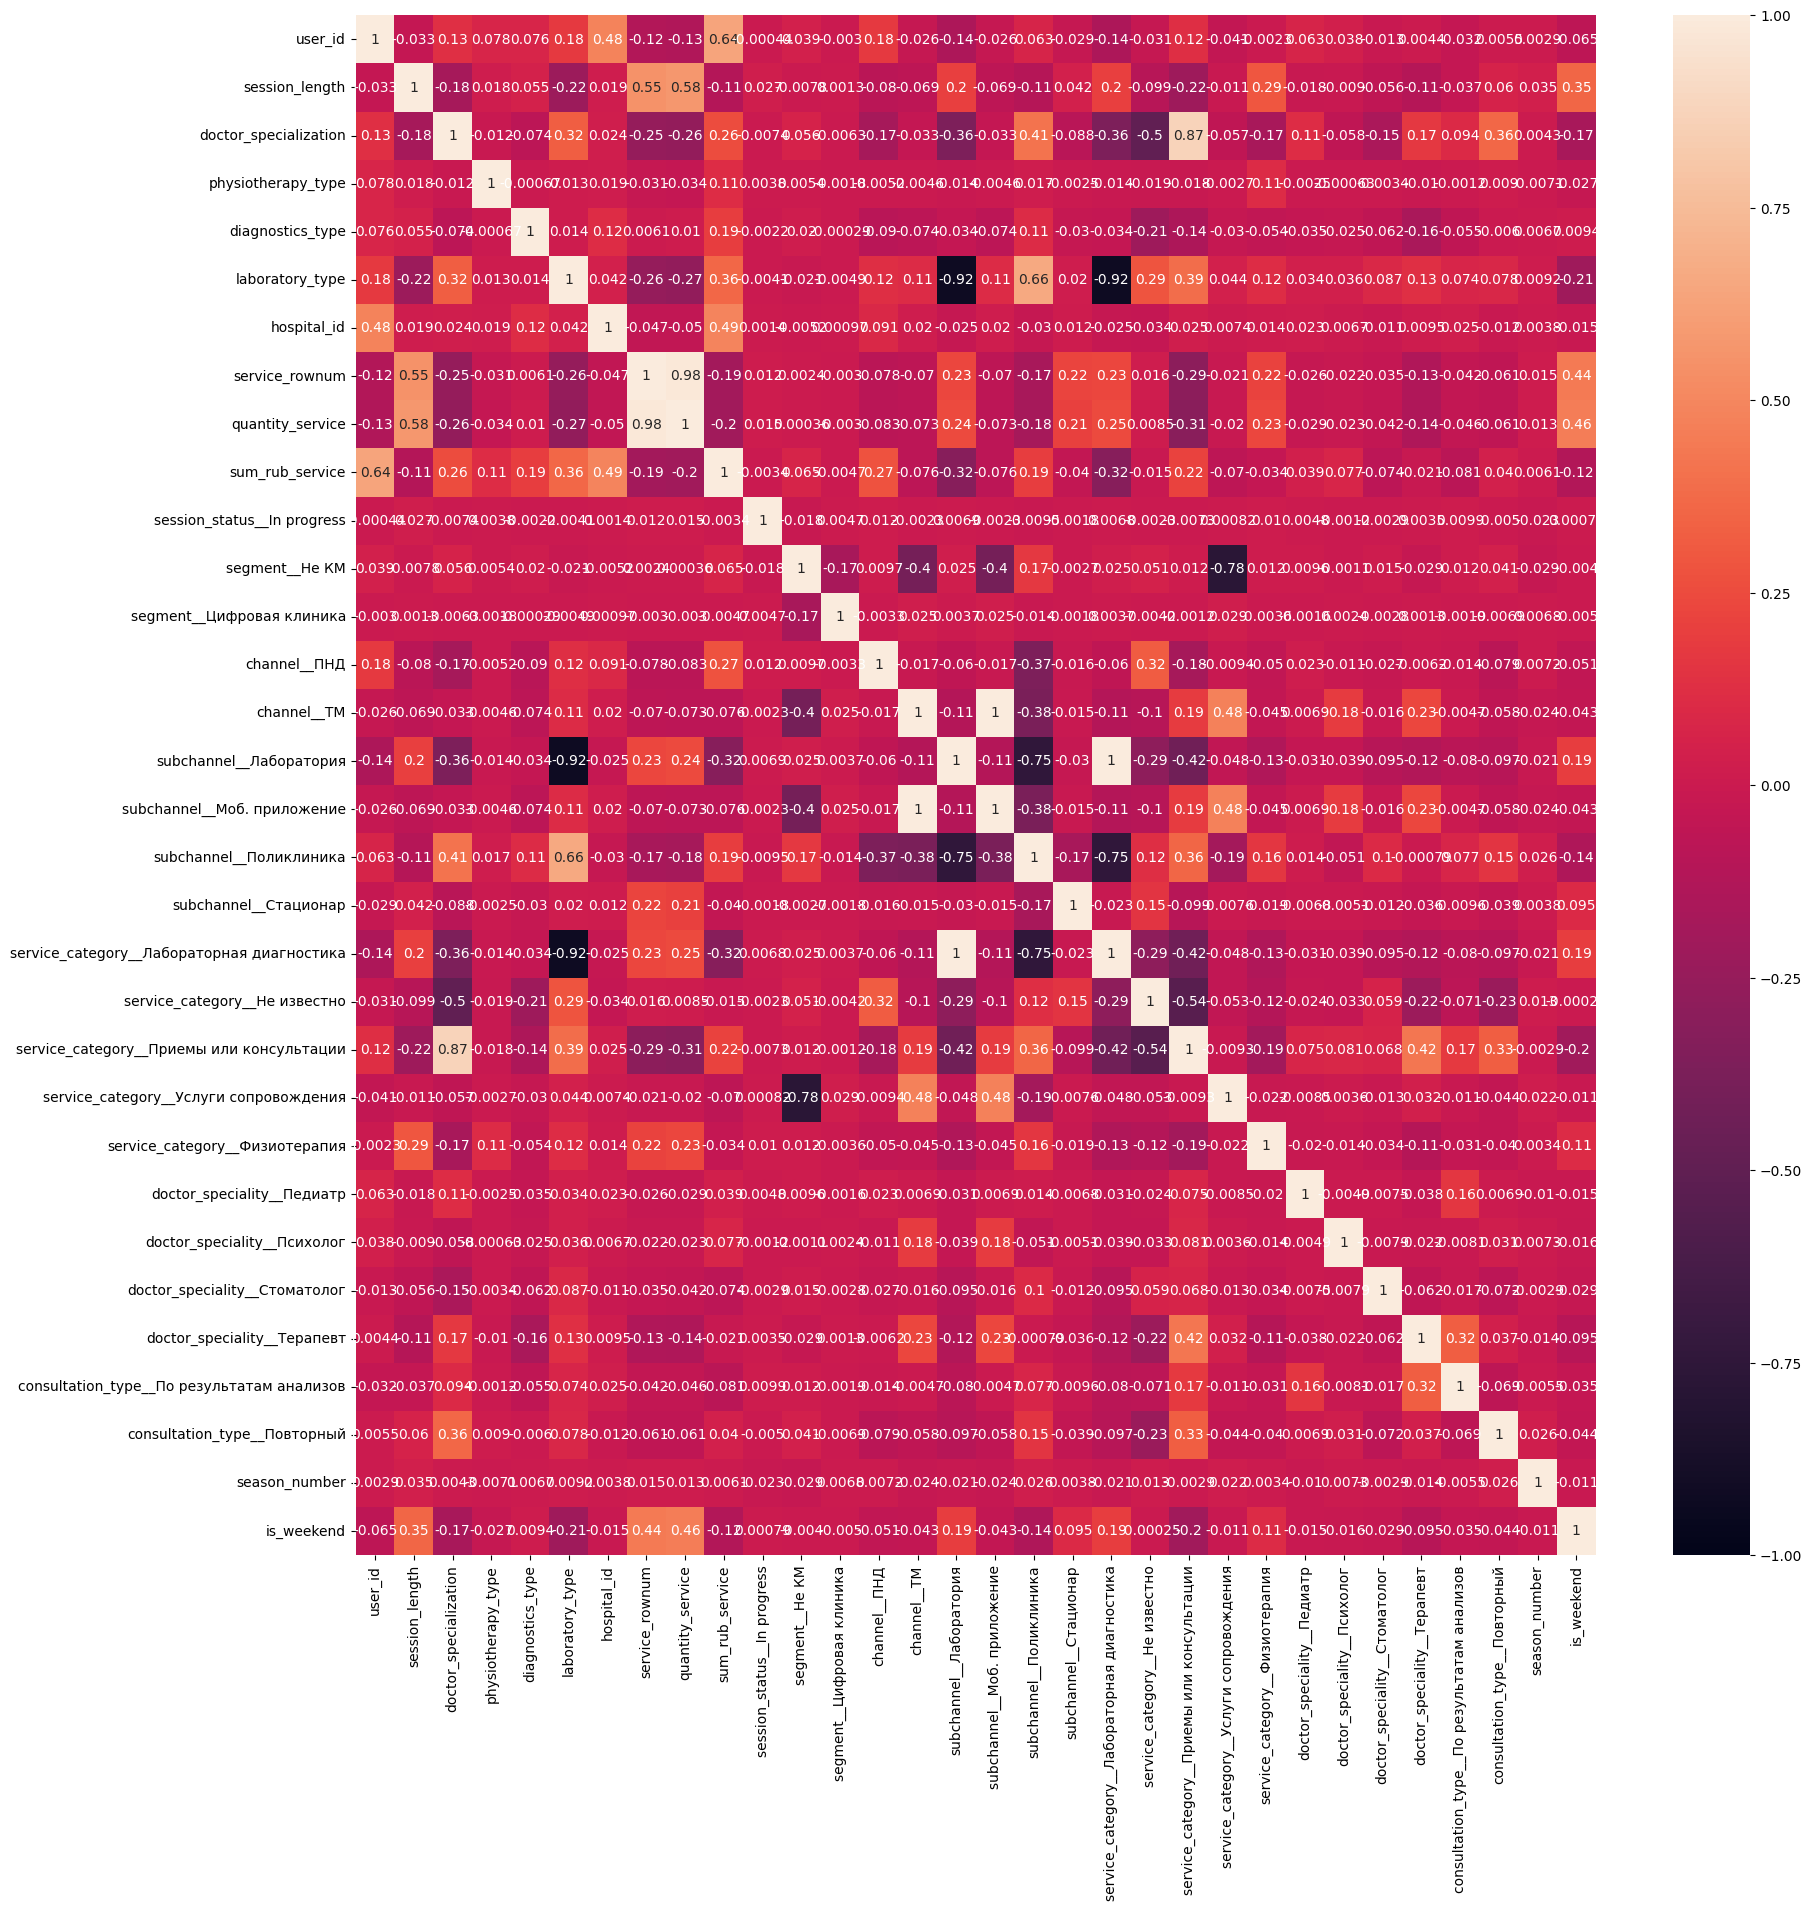

In [217]:
plt.figure(figsize = (20, 20))
sns.heatmap(data_prepared.loc[:,~data_prepared.columns.isin(['session_id'])].corr(),vmin = -1, vmax = 1,annot=True)

Удаляем колонки с высоким уровнем корреляции, для подсчета корреляции использую **VIF**

In [218]:
vif_data = pd.DataFrame()
vif_data["feature"] = data_prepared.loc[:,~data_prepared.columns.isin(['session_id'])].columns
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(data_prepared.loc[:,~data_prepared.columns.isin(['session_id'])].values, i)
                          for i in range(len(data_prepared.loc[:,~data_prepared.columns.isin(['session_id'])].columns))]
vif_data = vif_data.set_index('feature')

divide by zero encountered in double_scalars


In [219]:
vif_data.loc[vif_data['VIF'] >= 100, 'VIF'] = 100 #заменяем бесконечные зачения просто на 100, чтобы можно было проще отрисовать на графике

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]),
 [Text(0, 0, 'user_id'),
  Text(1, 0, 'session_length'),
  Text(2, 0, 'doctor_specialization'),
  Text(3, 0, 'physiotherapy_type'),
  Text(4, 0, 'diagnostics_type'),
  Text(5, 0, 'laboratory_type'),
  Text(6, 0, 'hospital_id'),
  Text(7, 0, 'service_rownum'),
  Text(8, 0, 'quantity_service'),
  Text(9, 0, 'sum_rub_service'),
  Text(10, 0, 'session_status__In progress'),
  Text(11, 0, 'segment__Не КМ'),
  Text(12, 0, 'segment__Цифровая клиника'),
  Text(13, 0, 'channel__ПНД'),
  Text(14, 0, 'channel__ТМ'),
  Text(15, 0, 'subchannel__Лаборатория'),
  Text(16, 0, 'subchannel__Моб. приложение'),
  Text(17, 0, 'subchannel__Поликлиника'),
  Text(18, 0, 'subchannel__Стационар'),
  Text(19, 0, 'service_category__Лабораторная диагностика'),
  Text(20, 0, 'service_category__Не известно'),
  Text(21, 0, 'service_category__Приемы или консультации'),
  Te

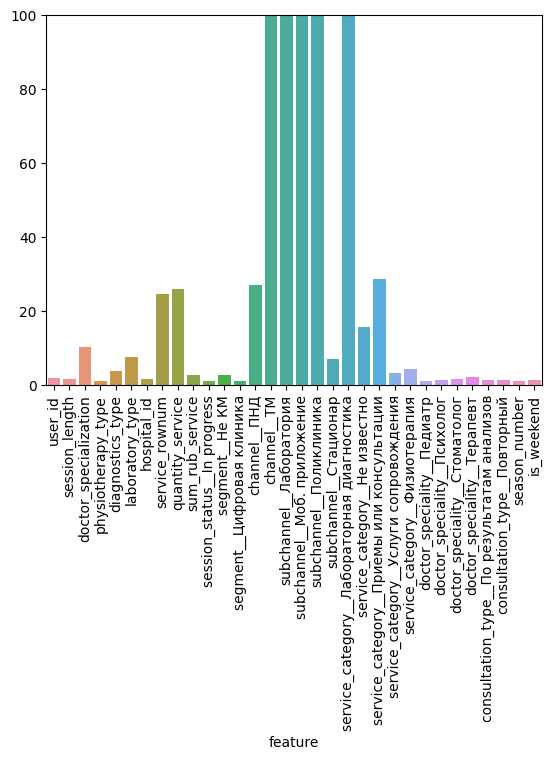

In [220]:
sns.barplot(vif_data.T)
plt.ylim([0,100])
plt.xticks(rotation=90)

In [221]:
data_prepared = data_prepared.drop(vif_data[vif_data.columns[vif_data.iloc[0] >=10]].columns,axis=1)#удаляем из анализа колонки с VIF>=10

### Выбор и обучение модели

Шкалируем данные с помощью **StandardScaler**

In [222]:
sc = StandardScaler()
X = sc.fit_transform(data_prepared.drop('sum_rub_service',axis=1))
y = data_prepared['sum_rub_service']

In [223]:
X = pd.DataFrame(X,columns=data_prepared.drop('sum_rub_service',axis=1).columns)

In [224]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)# создаем тренировочные и тестовые данные

In [225]:
#Отбираем несколько моделей для сравнения
regressors = [
    KNeighborsRegressor(),
    GradientBoostingRegressor(random_state=0),
    RandomForestRegressor(random_state=0),
    DecisionTreeRegressor(random_state=0),
    LinearRegression(),
    Lasso(random_state=0),
    Ridge(random_state=0),
    xg.XGBRegressor(random_state=0)
]

In [226]:
#Проводим оценку качества моделей
for model in regressors:
    start = time()
    model.fit(X_train, y_train)
    train_time = time() - start
    start = time()
    y_pred = model.predict(X_test)
    predict_time = time()-start    
    print(model)
    print("\tTraining time: %0.3fs" % train_time)
    print("\tPrediction time: %0.3fs" % predict_time)
    print("\tExplained variance:", explained_variance_score(y_test, y_pred))
    print("\tMean absolute error:", mean_absolute_error(y_test, y_pred))
    print("\tR2 score:", r2_score(y_test, y_pred))
    print()

KNeighborsRegressor()
	Training time: 0.011s
	Prediction time: 4.232s
	Explained variance: 0.6407487098291212
	Mean absolute error: 235.28917916800646
	R2 score: 0.6406557378605621

GradientBoostingRegressor(random_state=0)
	Training time: 32.406s
	Prediction time: 0.032s
	Explained variance: 0.6685676050788718
	Mean absolute error: 224.92696392821017
	R2 score: 0.6685461448484167

RandomForestRegressor(random_state=0)
	Training time: 132.907s
	Prediction time: 0.992s
	Explained variance: 0.6974505472951618
	Mean absolute error: 209.9434887284286
	R2 score: 0.6971883289818958

DecisionTreeRegressor(random_state=0)
	Training time: 2.036s
	Prediction time: 0.013s
	Explained variance: 0.37659854837102325
	Mean absolute error: 300.51370664462934
	R2 score: 0.37616278608965315

LinearRegression()
	Training time: 0.106s
	Prediction time: 0.011s
	Explained variance: 0.6279909558267873
	Mean absolute error: 241.07503011792488
	R2 score: 0.6279773163354927

Lasso(random_state=0)
	Training time:

лучше всего отработал **XGBRegressor**, возьмем его для подбора параметров обучения

In [227]:
xgb1 = xg.XGBRegressor(random_state=0)
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07,.09], #so called `eta` value
              'max_depth': [7,10],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 2,
                        verbose=True,scoring='r2')

xgb_grid.fit(X_train,
         y_train)

y_pred = xgb_grid.best_estimator_.predict(X_test)
print("\tExplained variance:", explained_variance_score(y_test, y_pred))
print("\tBest params:", xgb_grid.best_params_)

Fitting 2 folds for each of 8 candidates, totalling 16 fits
[14:55:49] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[14:55:49] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[14:56:12] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[14:56:12] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[14:56:36] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[14:56:36] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[14:57:11] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[14:57:11] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[14:57:46] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[14:57:46

Теперь отрисовывем наиболее важные фичи

In [232]:
explainer = shap.TreeExplainer(xgb_grid.best_estimator_)
shap_values = explainer.shap_values(X_test)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


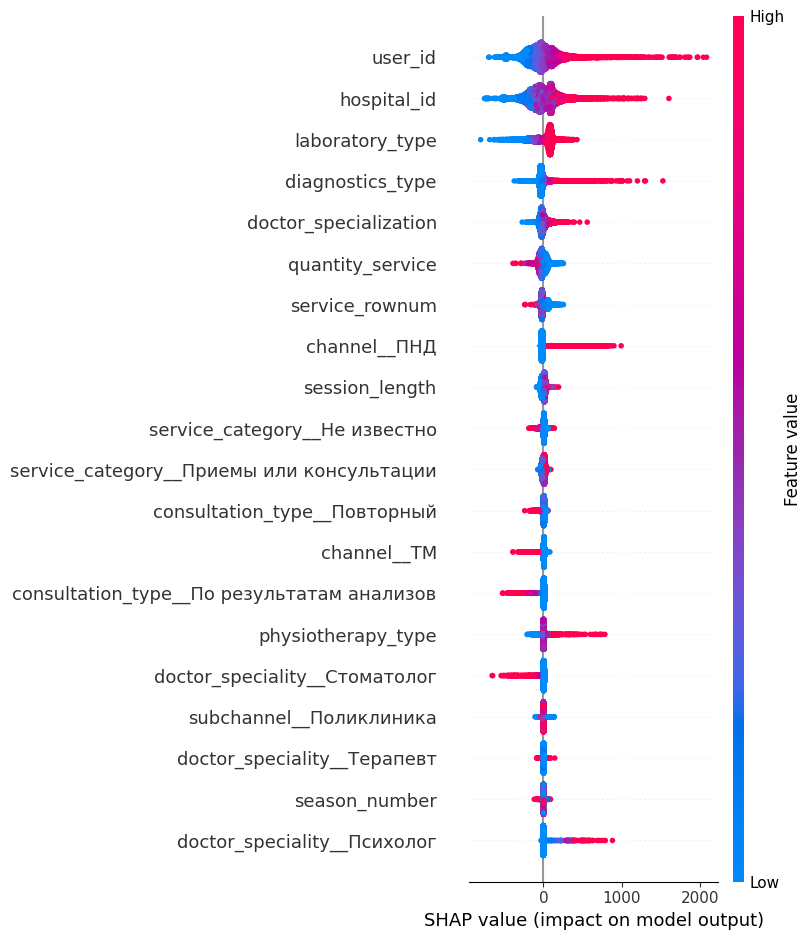

In [233]:
shap.summary_plot(shap_values, X_test)

Здесь можно увидеть лучшие фичи